In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from Quantum_circuits import *

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:10000]
y_train = y_train[:10000]

x_test = x_test[:2000]
y_test = y_test[:2000]

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 10000
Number of original test examples: 2000


In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 2046
Number of filtered test examples: 385


True


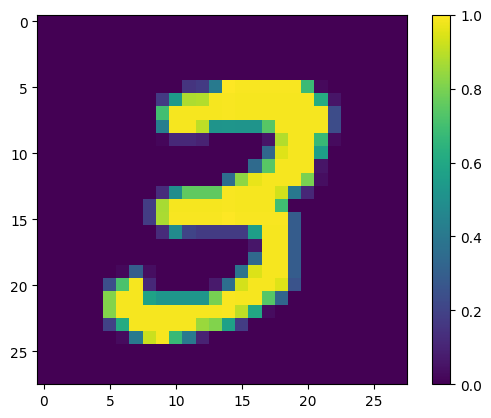

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [6]:
# Reshape the data: each image becomes a single 784-dimensional vector (28x28 pixels)
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Initialize PCA to keep 8 components
pca = PCA(n_components=8)

# Fit PCA on the training data and transform both training and test data
x_train_small = pca.fit_transform(x_train_reshaped)
x_test_small = pca.transform(x_test_reshaped)

In [7]:
def build_rbs(circuit, q0, q1, symbol):
    circuit.append(cirq.Moment([cirq.H(q0), cirq.H(q1)]))
    circuit.append(cirq.CZ(q0, q1))
    circuit.append(cirq.Moment([cirq.ry(symbol / 2)(q0), cirq.ry(-symbol / 2)(q1)]))
    circuit.append(cirq.CZ(q0, q1))
    circuit.append(cirq.Moment([cirq.H(q0), cirq.H(q1)]))

In [8]:
def convert_to_circuit(image):
    circuit = cirq.Circuit()
    qubits = [cirq.LineQubit(i) for i in range(8)]
    
    values = np.ndarray.flatten(image)
    array = tf.constant(values)
    alphas = convert_array(array)
    vector_loader(circuit, alphas, is_x=True, is_conjugate=False)
    return cirq.Circuit(cirq.decompose(circuit))
convert_to_circuit(x_train_small[0])
x_train_circ = [convert_to_circuit(x) for x in x_train_small]
x_test_circ = [convert_to_circuit(x) for x in x_test_small]

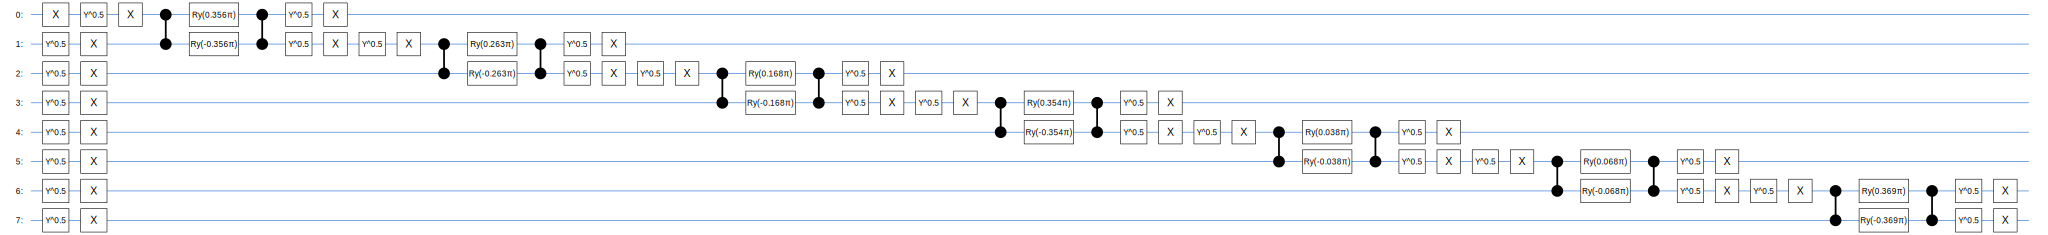

In [9]:
SVGCircuit(x_train_circ[0])

In [10]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [11]:
def butterfly_circuit(circuit, parameters, wires=None):
    # If wires is None, use all qubits in the circuit
    if wires is None:
        wires = list(circuit.all_qubits())
        length = len(wires)
    else:
        # If wires is not None, ensure it's a list of qubits
        length = len(wires)
    if length > 1:
        n=length//2
        x = 0
        for i in range(n):
            build_rbs(circuit, wires[i], wires[i+n], parameters[x])
            x += 1
        butterfly_circuit(circuit, parameters[x: (len(parameters)//2 + x//2) ], wires = wires[:n])
        butterfly_circuit(circuit, parameters[(len(parameters)//2 + x//2):], wires = wires[n:])

def pyramid_circuit(circuit, parameters, wires=None):
    # If wires is None, use all qubits in the circuit
    if wires is None:
        wires = list(circuit.all_qubits())
        length = len(wires)
    else:
        # If wires is not None, ensure it's a list of qubits
        length = len(wires)

    k = 0  

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < len(parameters):
                    build_rbs(circuit, wires[_], wires[_ + 1], parameters[k])
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < len(parameters):
                    build_rbs(circuit, wires[_], wires[_ + 1], parameters[k])
                    k += 1

class CircuitLayerBuilder():
    def __init__(self, data_qubits):
        self.data_qubits = data_qubits

    def add_layer(self, circuit, gate, prefix):
        for i in range(len(self.data_qubits) - 2, -1, -1):
            symbol = sympy.Symbol(prefix + '-' + str(i )) 
            q0, q1 = self.data_qubits[i], self.data_qubits[i + 1]
            build_rbs(circuit, q0, q1, symbol)
        circuit.append(cirq.X(self.data_qubits[0]))

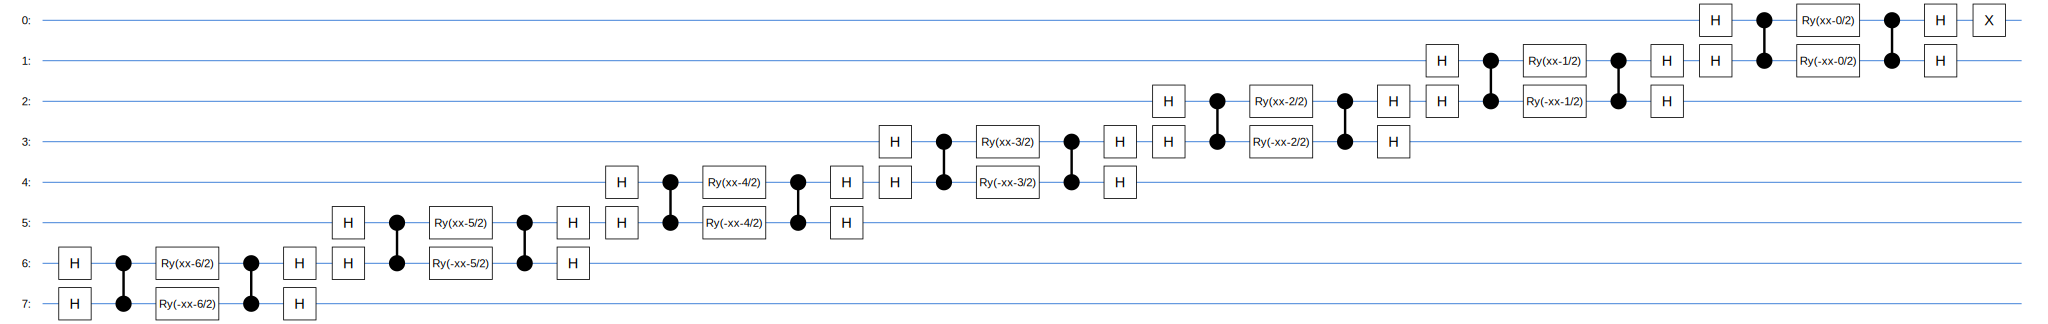

In [12]:
demo_builder = CircuitLayerBuilder(data_qubits = [cirq.LineQubit(i) for i in range(8)])

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

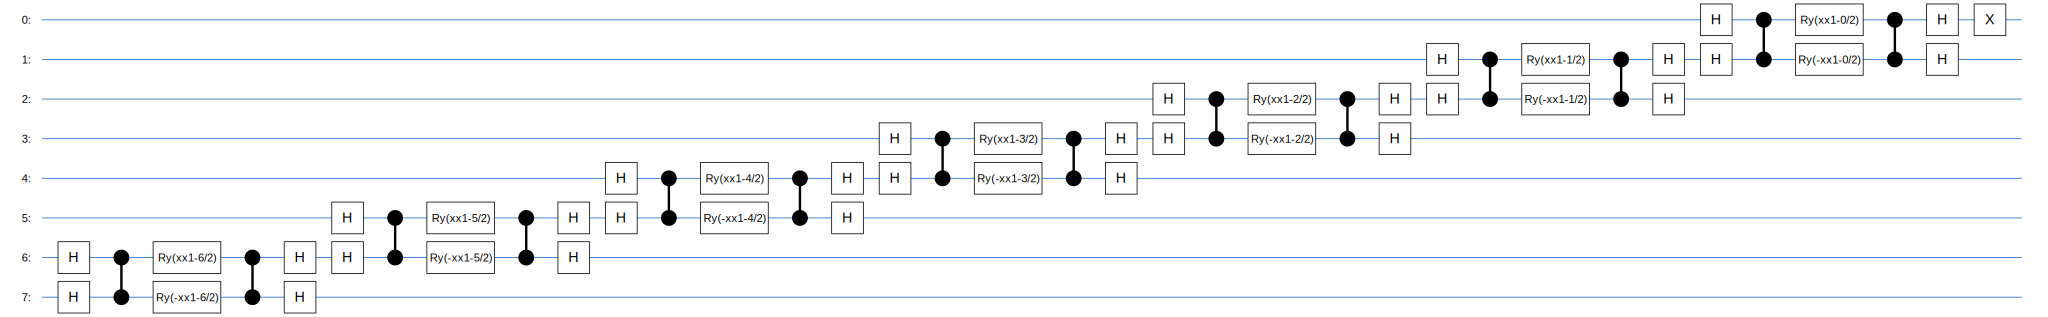

In [13]:
def create_quantum_model(num_qubits=8, layers=[("XX", cirq.XX)]):
    """Create a QNN model circuit with a specific number of qubits and layers.
    
    Args:
        num_qubits: The number of qubits in the grid.
        layers: A list of tuples representing layers, where each tuple contains
                a prefix for the layer and the gate to be used in that layer.

    Returns:
        A tuple of the model circuit and the model readout operation.
    """
    # Initialize qubits.
    data_qubits = [cirq.LineQubit(i) for i in range(num_qubits)]
    
    # Define the circuit.
    circuit = cirq.Circuit()
    
    # Instance of CircuitLayerBuilder
    builder = CircuitLayerBuilder(data_qubits=data_qubits)
    
    # Add specified layers.
    for prefix, gate in layers:
        builder.add_layer(circuit, gate, prefix)
    
    # readout qubit
    readout = data_qubits[0]

    # Return the circuit and a readout operation,measuring the Z observable on the readout qubit
    return circuit, cirq.Z(readout)

# Example usage of model creation function
num_qubits = 8
layers = [("xx1", cirq.XX)]  
model_circuit, model_readout = create_quantum_model(num_qubits=num_qubits, layers=layers)

SVGCircuit(model_circuit)

In [14]:
model_circuit, model_readout = create_quantum_model()

In [15]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
    # custom layer to square the output
    tf.keras.layers.Lambda(lambda x: tf.square(x)),
])

In [16]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [17]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [18]:
model.compile(
    loss='mse',  
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    metrics=['mae'])

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 7         
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
EPOCHS = 2
BATCH_SIZE = 1

NUM_EXAMPLES = min(len(x_train_tfcirc), len(y_train))

In [21]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_sub = y_train[:NUM_EXAMPLES]

In [22]:
EPOCHS = 3  
BATCH_SIZE = 32

qnn_history = model.fit(
    x_train_tfcirc, y_train,  
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test_tfcirc, y_test))

Epoch 1/3
64/64 [==============================] - 25s 365ms/step - loss: 0.0351 - mae: 0.1216 - val_loss: 0.0356 - val_mae: 0.1286
Epoch 2/3
64/64 [==============================] - 14s 217ms/step - loss: 0.0267 - mae: 0.1010 - val_loss: 0.0372 - val_mae: 0.1345
Epoch 3/3
64/64 [==============================] - 20s 310ms/step - loss: 0.0264 - mae: 0.1000 - val_loss: 0.0359 - val_mae: 0.1301


In [23]:
res = model.predict(x_test_tfcirc)
binary_predictions = (res > 0.5).astype(int)
y_pred = np.array(y_test).reshape(-1, 1).astype(int)
correct_predictions = binary_predictions == y_pred
accuracy = correct_predictions.mean()
print(f"accuracy: {accuracy}")

13/13 [==============================] - 2s 178ms/step
accuracy: 0.9766233766233766
